## Introduction 

"Vector Quantization." Sounds intimidating. "Residual Vector Quantization" sounds even more intimidating, even near-meaningless to most people. Turns out, these are easy to understand given a few pictures, even to the point a child could understand them -- uh... if the child *wanted* to.  Certainly, there can be sophisticated ways to implement these algorithms, and we'll cover a bit of that later on, but the basics are very simple.

Residual Vector Quantization (RVQ) is found in state-of-the-art neural audio codecs such as Google's [SoundStream](https://ai.googleblog.com/2021/08/soundstream-end-to-end-neural-audio.html), and Facebook/Meta AI's [Encodec](https://github.com/facebookresearch/encodec), which in turn form the backbone of generative audio models such as [AudioLM](https://google-research.github.io/seanet/audiolm/examples/) (Google) and [MusicGen](https://ai.honu.io/papers/musicgen/) (Facebook). 
What is it and how does it work?  

First we should consider regular vector quantization (VQ). VQ has been around for decades, and it shows up in many areas of signal processing when compression is involved. 

> Note: Whenever I say something that applies to both VQ and RVQ, I'll use the abbreviation "(R)VQ." 

## Vector Quantization = Partitioning Space

"Vector Quantization" is really about dividing up the space of your data points into a discrete set of regions.  Put differently, we "partition" the space. 

Let's we have a bunch of points in space:

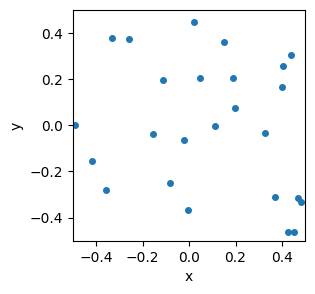

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-dots
#| fig-cap: "A set of data points, aka 'vectors'."


import numpy as np 
import matplotlib.pyplot as plt

# make some data
n_points = 25
DATA_MIN, DATA_MAX = -0.5, 0.5 # we'll let these be globals
np.random.seed(9)  # for reproducibility
data = DATA_MIN + (DATA_MAX-DATA_MIN)*np.random.rand(n_points, 2)

# plot it
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(DATA_MIN, DATA_MAX)
ax.set_ylim(DATA_MIN, DATA_MAX)
#ax.set_xticks([])  # hide axis ticks
#ax.set_yticks([])
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.scatter(data[:, 0], data[:, 1], s=16)
plt.show()

To computer scientists, the $(x,y)$ coordinates of each point define a "vector".  (To mathematicians and physicists, the "vector" points from the origin to each point, but that distinction isn't going to matter to us.) 

Now divide up the space into a bunch of regions.  How we do that can take many forms. There are algorithms to partition the space in a way that best "fits" the data (see "K-Means", below for such an algorithm).  For now, just consider the two examples of my hand drawing with colors, and a set of tiled squares:

<!--- ::: {layout-ncol=2 label="fig-region-options" fig-cap="Two ways of partitioning space"} -->

::: {#fig-regions2 layout-ncol=2}

![By hand](images/dots_square_handregions.png){#fig-hand}

![Squares](images/dots_squares_basic.png){#fig-lilsquares}

Examples of ways to divide up or "quantize" space, aka "Partitioning schemes."
:::

Moving forward, I can do a bit more code-wise with the squares, so let's start there. ;-) 

Let me just formalize that a bit.  We'll let the number of squares be controlled by the variable "`n_grid`". So for our two-dimensional examples, there will be `n_grid`$^2$ square regions. 

With vector quantization, we give an index value to every region (e.g. 0 to 24 for a 5x5 square grid), and then what we **replace each vector's value with the index of the of the region**. 

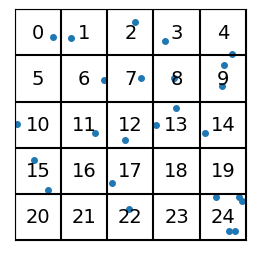

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-indices
#| fig-cap: "(Integer) Indices for each region."



#| code-fold: true
#| code-summary: "Show the code"
import pandas as pd 

def plot_data_grid(data, n_grid=5, hide_tick_labels=True, show_indices=False, show_centroids=False, 
                   show_next_level_grid=False):
    "big ol' workhorse plotting routine that we'll progressively make use of as the lesson proceeds"
    fig, ax = plt.subplots(figsize=(3,3))
    h = 1.0 / n_grid
    ax.set_xlim(DATA_MIN, DATA_MAX)
    ax.set_ylim(DATA_MIN, DATA_MAX)

    for i in range(n_grid + 1):
        ax.axhline(DATA_MIN + i*h, color='black')
        ax.axvline(DATA_MIN + i*h, color='black')
        
    if show_indices:
        index = 0
        for j in range(n_grid):
            for i in range(n_grid):
                x = DATA_MIN + (i + 0.5) / n_grid
                y = DATA_MIN + 1 - (j + 0.5) / n_grid
                ax.text(x, y, str(index), ha='center', va='center',fontsize=14)
                index += 1

    if show_centroids: 
        for j in range(n_grid):
            for i in range(n_grid):
                x = DATA_MIN + (i + 0.5)*h
                y = DATA_MIN + (j + 0.5)*h
                ax.plot(x, y, 'ro', markersize=6)
                
    if hide_tick_labels:
        ax.set_xticks([])
        ax.set_yticks([])

    ax.set_aspect('equal')
    if data is not None:
        plt.scatter(data[:, 0], data[:, 1], s=16)
    plt.show()
    
    
n_grid=5
#plot_data_grid(data, n_grid=n_grid)
plot_data_grid(data, n_grid=n_grid, show_indices=True)

For each of the "vectors" represented by the data points, we no longer use the ($x$,$y$) coordinate pairs, but rather the (integer) index of the region it's in. 

> Note that we've gone from needing two floating point numbers per point to just one integer value. In two dimensions, the "savings" or data-compression amount that we get from that may not be readily apparent, but stick around:  As we go to large numbers of dimensions later, this scheme will save us a *ton* of data.

If we want the coordinates that go with the indices, we'll use the centroid of each region.  In this sense, the vectors are "quantized" so that they can only take on values given by the centroids of the regions. In the following example, the centroids are shown in red:

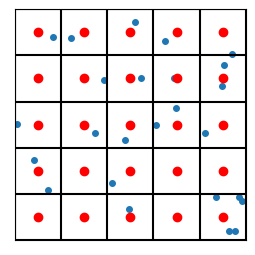

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-centroids
#| fig-cap: "Centroid locations"
plot_data_grid(data, n_grid=n_grid, show_indices=False, 
               show_centroids=True)

So each blue point will effectively be replaced by the nearest red point.  In this sense we have "quantized" the vectors (because we've quantized the space itself).

> **Terminology:** The set of locations of centroids is called the "**codebook**". When we want to use an actual vector value (in space), we convert the codebook index into a (centroid) location by looking up the codebook. 

<!--
For reasons of simplicity (/laziness) that will become clear later, for this blog post we'll choose coordinates where our space is centered on (0,0), and has a span of (1,1) across it. So that means the space will go from (-0.5,-0.5) to (0.5,0.5).  This choice of coordinates doesn't change the basic mechanics of (R)VQ, it just means less work to do later. -->

So a full (albeit unweidly) picture showing the data points, the region indices, and the centroids, looks like this: 

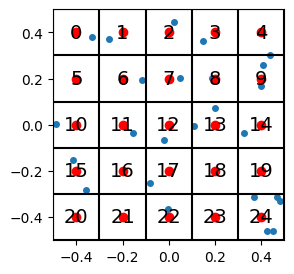

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-detailed-squares
#| fig-cap: "Detailed figure showing data points, region indices, and centroid locations."
plot_data_grid(data, n_grid=n_grid, show_indices=True, show_centroids=True, hide_tick_labels=False)

For our choice of coordinates, the codebook (i.e. the mapping of indices to centroid locations) looks like this:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

from IPython.display import display, Markdown

def generate_codebook(n_grid):
    "TODO: chatGPT wrote this code but I know I could write it more compactly if i cared to"
    codebook = np.zeros((n_grid**2, 2))
    index = 0
    for j in range(n_grid):
        for i in range(n_grid):
            x = DATA_MIN + (i + 0.5) / n_grid
            y = DATA_MIN + (j + 0.5) / n_grid
            codebook[index] = [x, y]
            index += 1
    return codebook

codebook = generate_codebook(n_grid)

# print it nicely
cb_str = f"| index      | vector |\n| ----------- | ----------- |"
for i in range(codebook.shape[0]):
    cb_str += f"\n| {i} | ({codebook[i,0]:.1f}, {codebook[i,1]:.1f}) |"
display(Markdown(cb_str))

| index      | vector |
| ----------- | ----------- |
| 0 | (-0.4, -0.4) |
| 1 | (-0.2, -0.4) |
| 2 | (0.0, -0.4) |
| 3 | (0.2, -0.4) |
| 4 | (0.4, -0.4) |
| 5 | (-0.4, -0.2) |
| 6 | (-0.2, -0.2) |
| 7 | (0.0, -0.2) |
| 8 | (0.2, -0.2) |
| 9 | (0.4, -0.2) |
| 10 | (-0.4, 0.0) |
| 11 | (-0.2, 0.0) |
| 12 | (0.0, 0.0) |
| 13 | (0.2, 0.0) |
| 14 | (0.4, 0.0) |
| 15 | (-0.4, 0.2) |
| 16 | (-0.2, 0.2) |
| 17 | (0.0, 0.2) |
| 18 | (0.2, 0.2) |
| 19 | (0.4, 0.2) |
| 20 | (-0.4, 0.4) |
| 21 | (-0.2, 0.4) |
| 22 | (0.0, 0.4) |
| 23 | (0.2, 0.4) |
| 24 | (0.4, 0.4) |

### (Quantization) Error 
When we do this quantization (i.e. replacing vectors by their nearest centroid), the centroid locations will naturally be a bit "off" compared to the original data vectors themselves.  The finer the grid you make, the smaller the regions, and the less error.  For a 2D grid, the error will be on the order of $h^2$ where $h$ is the grid spacing ($h = 1/5 = 0.2$ in our example).
Let's check how the error varies as we change the grid spacing or equivalently, `n_grid`). 

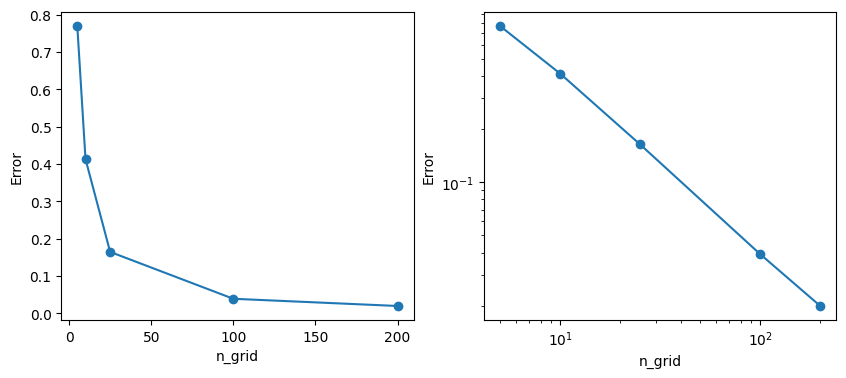

lowest error (for n_grid=200) =  0.019903707672610255


In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-error
#| fig-cap: "Plots of error vs. resolution with linear (left) and logarithmic (right) axes. Note that the computational cost will scale like the number of regions, which is `n_grid`$^2$."
def find_closest_centroids(data, codebook):
    distances = np.sum((data[:, np.newaxis] - codebook) ** 2, axis=2)
    closest_centroids = np.argmin(distances, axis=1)
    return closest_centroids # indices not coordinates

def compute_error(data, codebook):
    n_grid = int(np.sqrt(codebook.shape[0]))
    h = 1/n_grid * (DATA_MAX - DATA_MIN) 
    quantized_ind = find_closest_centroids(data, codebook)
    quantized_xy = codebook[quantized_ind]       
    error = np.sqrt( np.sum( (data - quantized_xy)**2 ) )
    return error 

n_points2 = 100
data2 = DATA_MIN + (DATA_MAX - DATA_MIN)*np.random.rand(n_points2, 2)

errors = []
grids = np.array([5,10,25,100,200])
for n_grid2 in grids:
    codebook = generate_codebook(n_grid2)
    error = compute_error(data2, codebook)               
    errors.append(error)
    
fig, ax = plt.subplots(1,2, figsize=(10,4))    
ax[0].plot(grids, errors, 'o-')
ax[1].loglog(grids, errors, 'o-')
for i in range(2):
    ax[i].set_ylabel('Error')
    ax[i].set_xlabel('n_grid')
plt.show()
print(f"lowest error (for n_grid={grids[-1]}) = ",errors[-1])


So, the more "gridlines" you use, the lower the error, but at what cost?  To get an error of 0.02 we need $200^2 = 400$ regions. And in higher dimensions than 2, the "cost" of higher resolution / lower error goes up *immensely*: to double the resolution in $d$ dimensions, the computational cost goes up by a factor of $2^d$. (Imagine $d$=32, 64, 128,...) 

But we don't need to cover the entire space uniformly! That's where Residual Vector Quantization comes in. 

## Residual Vector Quantization (RVQ)

The trick with RVQ is, rather than having a single high-resolution codebook, to instead have "codebooks inside of codebooks", or, if you like, "stacking codebooks".  Let's say we want to quintuple the resolution of our initial 5x5 grid.  Instead of using a 25x25 grid (which would be 25x the computational cost of the original), what if we put a little 5x5 grid "inside" the region to which a vector was quantized? 

For example, in the "middle" region (region 12), we can do...

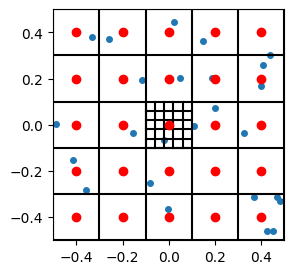

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-basic
#| fig-cap: "Illustration of 'codebook within a codebook', with a smaller 5x5 codebook which will be relative to the middle region's codebook."

from matplotlib import collections  as mc


def get_region_membership(data:np.array, n_grid=5,):
    "Tells which region each point is in. TBD: this is slow but it works! ;-) "
    h = (DATA_MAX - DATA_MIN)/n_grid
    memb = np.zeros(data.shape[0], dtype=np.int32)
    for di, p in enumerate(data):
        i = (p[0]-DATA_MIN) // h
        j = (p[1]-DATA_MIN) // h
        ind = i + j*n_grid
        memb[di] = ind
    return memb


def plot_data_grid_with_resids(data, n_grid=5, hide_tick_labels=True, show_indices=False, show_centroids=False, 
                   show_next_level_grid=False, show_resids=True, codebook=None, show_grid=True):
    "big ol' workhorse plotting routine that we'll progressively make use of as the lesson proceeds"
    fig, ax = plt.subplots(figsize=(3,3))
    h = 1.0 / n_grid
    ax.set_xlim(DATA_MIN, DATA_MAX)
    ax.set_ylim(DATA_MIN, DATA_MAX)

    if show_grid:
        for i in range(n_grid + 1):  
            ax.axhline(DATA_MIN + i*h, color='black')
            ax.axvline(DATA_MIN + i*h, color='black')
        
    if show_next_level_grid: # draws lines in the middle
        x_start = 2*h
        y_start = -h/2
        for i in range(n_grid): # horizontal lines
            y = y_start + i*h/n_grid
            ax.axhline(y, xmin=x_start, xmax=x_start+h, color='black')
        y_start, x_start = x_start, y_start
        for j in range(n_grid): # horizontal lines
            x = x_start + j*h/n_grid
            ax.axvline(x, ymin=y_start, ymax=y_start+h, color='black')
        
    if show_indices:
        index = 0
        for j in range(n_grid):
            for i in range(n_grid):
                x = DATA_MIN + (i + 0.5) / n_grid
                y = DATA_MIN + 1 - (j + 0.5) / n_grid
                ax.text(x, y, str(index), ha='center', va='center',fontsize=14)
                index += 1

    if show_centroids: 
        for j in range(n_grid):
            for i in range(n_grid):
                x = DATA_MIN + (i + 0.5)*h
                y = DATA_MIN + (j + 0.5)*h
                ax.plot(x, y, 'ro', markersize=6)
                
    if show_resids and codebook is not None:
        memb = get_region_membership(data)
        resids = data*0
        lines = []
        for i, p in enumerate(data):
            #resids[i] = p - codebook[memb[i]] # don't actually need to compute resids for this
            lines.append([p, codebook[memb[i]] ] )
        lc = mc.LineCollection(lines, colors=(1,0,1,1), linewidths=2)
        ax.add_collection(lc)
        
    if hide_tick_labels:
        ax.set_xticks([])
        ax.set_yticks([])

    ax.set_aspect('equal')
    if data is not None:
        plt.scatter(data[:, 0], data[:, 1], s=16)
    plt.show()
    
    
n_grid=5
plot_data_grid_with_resids(data, n_grid=n_grid, show_next_level_grid=True, show_centroids=True, 
                           hide_tick_labels=False, codebook=codebook, show_resids=False)


The difference between that blue point in the middle "main" square and its corresponding red centroid will be the "residual". We will also quantize that within the "little" 5x5 grid. This will serve as a codebook to use "after" the original codebook.  And we'll get the same resolution as if we had a 25x25 grid, except our computational cost will instead be 2\*(5\*5)=50 instead of 25\*25=625!  So our cost will be 12.5 smaller than the full-grid approach. 

And interestingly, if we only consider the *residual*, i.e. the difference between the main centroid and the vector in question, then we can use the same "next level" codebook for *all* points in the space! 
In the following figure, we show the residuals as purple line segments that run from each point to its corresponding nearest centroid:

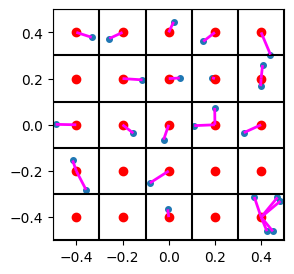

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-resids
#| fig-cap: "Illustration of redisuals, shown as purple line segments connecting vectors (blue points) with their nearest centroids (red points)."
plot_data_grid_with_resids(data, n_grid=n_grid, show_next_level_grid=False, show_centroids=True, 
                           hide_tick_labels=False, codebook=codebook, show_resids=True)

Note, because of a clever way we've set up our axes in this example (i.e., centered at the origin), we can treat the original data points as a "residual" relative to the "centroid" of the whole domain, namely the origin!

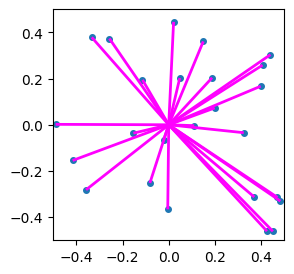

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-rvq-zero
#| fig-cap: "How we can treat the data points themselves as a residuals relative to the origin, for a 'level 0' codebook"
plot_data_grid_with_resids(data, n_grid=n_grid, show_next_level_grid=False, show_centroids=False, 
                           hide_tick_labels=False, codebook=np.zeros((data.shape[0],2)), show_resids=True, show_grid=False)

Also because of our clever choice of coordinates,  for the next "level" of quantization, we can take the codebook at the next level to be just the previous codebook divided by `n_grid`!  This won't always be the case; I'm just feeling clever and lazy. 

## Quantizer algorithm
Let's write a general quantizer for any "level" of codebook.  It will take our data points and return the various levels of codebook indices.  This will be the actual "Algorithm 1" from the SoundStream paper. 

In [ ]:
def quantizer(data, n_grid, level=0, domain_min=-0.5, domain_max=0.5, prev_codebook=None, prev_codebook_inds=None):
    h = ((DATA_MAX - DATA_MIN)/n_grid)**(level+1)
    # basically make this the algorithm from SoundStream
"TBD. More to do!"    

'TBD. More to do!'

---
...Stopping here for now. -SH

## Optional: K-Means
The k-means algorithm is another method to partition space, a method that 
instead of static squares, will allow our regions and centroids "follow the data". Often k-means is used to *initialize* an RVQ codebook for neural codecs (e.g. in SoundStream, Encodec, etc), after which the rest of the neural network's training algorithm may refine the codebooks more. 

Note however, that this discussion on K-means is actually not crucial to understanding (R)VQ.  At all. 

It's quite skippable, to be honest.  So...only read if you're really curious.

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-kmeans-init
#| fig-cap: "Initial state of k-means, showing data without any 'membership' (dark dots) and random centroid locations (large colored dots)"
# lots of imports to try to get the plotly plots and animations to show!
import plotly.io as pio
pio.renderers.default='notebook'
import plotly.express as px 
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)


ndim = 2  # easier to do in 2d at first
npoints = 100
np.random.seed(1)
datak = DATA_MIN + (DATA_MAX-DATA_MIN)*np.random.rand(npoints, ndim)   # make up some random data points

k = 5        # k-means parameter: number of clusters

# start with random centroids
centroids = DATA_MIN + 0.2+0.6*(DATA_MAX-DATA_MIN)*np.random.rand(k, ndim) # don't let the starting centroids be on the far edges of the plot
orig_centroids = centroids.copy() # save these for later when we'll make a movie


def plot_kmeans(data, centroids, cluster_memb=None): # we'll leave a way to color the data points
    all_data = np.concatenate((data,centroids))
    is_centroid = np.array( [1 if i >= npoints else 0 for i in range(all_data.shape[0])] , np.newaxis)
    sizes = is_centroid*3 + 1
    cs = cluster_memb if cluster_memb is not None else -1+np.zeros( (data.shape[0],1) ,dtype=int) 
    cs = np.append(cs, range(k)) # add the centroids
    plot_data = np.column_stack( (all_data, sizes, cs) )
    columns = ['x','y','sizes','cluster']
    df = pd.DataFrame( plot_data,  columns=columns)
    fig = px.scatter(df, x="x", y="y", color='cluster', size='sizes', width=550, range_color=(-1,k),
            color_continuous_scale='Turbo')
    return fig

plot_kmeans(datak, centroids)
    

That's our starting points.  Then what we'll do is, we'll color each point according to which centroid it's closest to. 

> Yes, this can be *very slow* for lots of points in many dimensions. There is a whole field of study of how to speed up "nearest neighbors" types of algorithms.  We're going to keep it simple for this demo:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-kmeans-first
#| fig-cap: "First step in k-means: Assign 'membership' of datapoints to different clusters based on which centroids (large dots) are nearest. Note that the 'centroids' in this graph aren't true centroids yet. We'll fix them in the next step after this."

def distance(p1, p2):
    "euclidean distance squared. we don't need the square root b/c we're only interested in ordering by distance"
    return np.sum((p1-p2)**2, axis=1)

def calc_cluster_membership(data, centroids):
    min_ds = 9999*np.ones(npoints)
    cluster_memb = np.zeros(npoints, dtype=int)-1
    for i, c in enumerate(centroids): # compute distances for all points
        ds = distance(data, c)
        inds = np.argwhere(ds < min_ds)
        if inds.size > 0: 
            min_ds[inds] = ds[inds]
            cluster_memb[inds] = i
    assert len(cluster_memb)==npoints # we're not including the centroids themselves here
    return cluster_memb

cluster_memb = calc_cluster_membership(datak, centroids)
plot_kmeans(datak, centroids, cluster_memb=cluster_memb)

The next step is to recalculate the centroid locations using the points that were assigned to each centroid. And these centroids are just the mean value of the points. 

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-kmeans-centroids
#| fig-cap: "Next step in k-means: move centroids so they are in the middle of each cluster"

def move_centroids(centroids, data, cluster_memb):
    for ki in range(centroids.shape[0]):
        inds = np.argwhere( cluster_memb == ki)
        if inds.size > 0:
            for dim in range(data.shape[-1]):
                centroids[ki,dim] = np.mean(data[inds,dim], axis=0)
    return centroids

centroids = move_centroids(centroids, datak, cluster_memb)
#print("These centroids should be fairly 'centered' in their respective groups of data.")
plot_kmeans(datak, centroids, cluster_memb=cluster_memb)

...But now, having moved the centroids, the nearest-neighbor membership of some of the points may have changed. 
So we recalculate those:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
#| label: fig-kmeans-re-member
#| fig-cap: "Next step in k-means: re-assign cluster membership of point based on new cluster locations"

cluster_memb = calc_cluster_membership(datak, centroids)
plot_kmeans(datak, centroids, cluster_memb=cluster_memb)

...And we repeat the process until some stopping criterion is met. For example we may just set a maximum iteration number, or we may stop when the centroids stop moving, or the cluster membership stops changing, etc. 
For this demo, we'll just use a maximum number of iterations. 

So, a movie of the whole process can look like this: 

In [ ]:
#| code-fold: true
#| code-summary: "Show the code" 
#| label: fig-kmeans-movie
#| fig-cap: "In this movie, each step will either be the 'membership' step or the 'centroid moving' step."


centroids = orig_centroids.copy() # start over
cluster_memb = -1+np.zeros( (datak.shape[0],1) ,dtype=int) 
maxiter = 10
plot_kmeans(datak, centroids, cluster_memb=cluster_memb)
ts = np.arange(2*maxiter,dtype=int)

columns = ['t','x','y','sizes','cluster','point_number']
total_points = npoints + k  # points + clusters
movie_data = np.zeros( (len(ts)*total_points, len(columns)) )  # giant data array for all data points at all times
movie_data[:,0] = np.repeat(ts, total_points)          # t

xs = np.concatenate( ( datak[:,0], centroids[:,0] ) ) # initial xs
ys = np.concatenate( ( datak[:,1], centroids[:,1] ) ) # initial ys
movie_data[:,1] = np.tile(xs, len(ts))
movie_data[:,2] = np.tile(ys, len(ts))

sizes = np.ones(total_points,dtype=int)
sizes[-k:] = 3
movie_data[:,3] = np.tile(sizes, len(ts)) # sizes is repeated for all times

cs = -2 + np.ones(total_points,dtype=int)
cs[-k:] = np.arange(k, dtype=int)
movie_data[:,4] = np.tile(cs, len(ts))

movie_data[:,5] = np.tile(np.arange(total_points), len(ts))  # point_number is repeated for all time

for t in ts:
    if t==0: 
        continue # leave initial data as step 0
    elif t % 2 == 1: 
        cluster_memb = calc_cluster_membership(datak, centroids)
    else:
        centroids = move_centroids(centroids, datak, cluster_memb)

    start, end = t*total_points, (t+1)*total_points  
    movie_data[start:end, 1] = np.concatenate( (datak[:,0], centroids[:,0]) )    # xs
    movie_data[start:end, 2] = np.concatenate( (datak[:,1], centroids[:,1]) )    # ys
    movie_data[start:end, 4] = np.concatenate( (cluster_memb, np.arange(k, dtype=int)) )  # cluster membership
    
    
df = pd.DataFrame(movie_data, columns=columns)
#df['cluster'] = df['cluster'].astype(int).astype(str) # use discrete colormap
#display(df)


fig = px.scatter(df, x="x", y="y", animation_frame="t", animation_group="point_number",
           color="cluster", hover_name="cluster", hover_data=['point_number'],
           size='sizes', width=550, height=600, range_color=(-1,k), color_continuous_scale='Turbo'
           )
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0 # don't interpolate frames
display(fig)
#print("Caption: In this movie, each step will either be the 'membership' step or \nthe 'centroid moving' step.")